In [5]:
# Install required packages
!pip install torch torch-geometric scikit-learn pandas networkx

In [6]:
# Upgrade pip
!pip install --upgrade pip

In [7]:
# All imports in one place
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
from torch_geometric.data import Data
import networkx as nx
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Load the Data and Preprocess

In [8]:
# Load the CSV data
student_data = pd.read_csv('synthetic_student_data.csv')

# Copy data for processing
student_data_processed = student_data.copy()

# Calculate Wellbeing Score
student_data_processed['Wellbeing_Score'] = (
    student_data_processed['pwi_wellbeing'] + student_data_processed['k6_overall']
) / 2

# Friendliness Score
student_data_processed['Friendliness_Score'] = student_data_processed['School_support_engage']

# Bullying Score
student_data_processed['Bullying_Score'] = student_data_processed['criticises']

# Normalize selected columns
scaler = MinMaxScaler()
student_data_processed[['Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score']] = scaler.fit_transform(
    student_data_processed[['Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score']]
)

# Composite Score
student_data_processed['Composite_Score'] = (
    0.7 * student_data_processed['Academic_Performance'] +
    0.2 * student_data_processed['Wellbeing_Score'] +
    0.1 * student_data_processed['Friendliness_Score']
)

# Identify potential bullies
student_data_processed['Potential_Bully'] = student_data_processed['Bullying_Score'] > 5

# Preview processed data
student_data_processed[[
    'StudentID', 'Academic_Performance', 'Wellbeing_Score',
    'Friendliness_Score', 'Bullying_Score', 'Composite_Score',
    'Potential_Bully'
]].head()

,StudentID,Academic_Performance,Wellbeing_Score,Friendliness_Score,Bullying_Score,Composite_Score,Potential_Bully
0,S0001,0.035714,0.2500,0.666667,6,0.141667,True
1,S0002,0.767857,0.5000,0.476190,1,0.685119,False
2,S0003,0.285714,0.6250,0.476190,7,0.372619,True
3,S0004,0.571429,0.8125,0.809524,6,0.643452,True
4,S0005,0.803571,0.0000,0.809524,3,0.643452,False


## Build the Edge List

In [9]:
# Build a mapping from StudentID to row index
student_id_to_idx = {sid: idx for idx, sid in enumerate(student_data_processed['StudentID'])}

# Build the edge list
edge_index_list = []
for idx, row in student_data_processed.iterrows():
    if pd.notna(row['Friends']):
        friends = row['Friends'].split(', ')
        for friend_id in friends:
            if friend_id in student_id_to_idx:
                edge_index_list.append([idx, student_id_to_idx[friend_id]])

# Convert to PyTorch tensor
edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()

print(f"Edge Index Shape: {edge_index.shape}")
print(f"Example Edges:\n{edge_index[:, :5]}")

Edge Index Shape: torch.Size([2, 209])
Example Edges:
tensor([[ 0,  0,  0,  0,  1],
        [28,  3, 36,  4, 26]])
Example Edges:
tensor([[ 0,  0,  0,  0,  1],
        [28,  3, 36,  4, 26]])


## Build Node Features

In [10]:
# Select features for node representation
node_features = student_data_processed[[
    'Academic_Performance', 'Wellbeing_Score',
    'Friendliness_Score', 'Bullying_Score',
    'Composite_Score'
]].values

# Convert to PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

print(f"Node Feature Shape: {x.shape}")

Node Feature Shape: torch.Size([50, 5])


## Build GNN Data Object

In [11]:
# Create PyG Data object
data = Data(x=x, edge_index=edge_index)

print(data)

Data(x=[50, 5], edge_index=[2, 209])


## Import Necessary GNN Layers

In [12]:
# (imports moved to top cell)

## Define a Simple 2-Layer GCN

In [13]:
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

## Initialize Model

In [14]:
# Initialize model
model = GCN(input_dim=5, hidden_dim=16, output_dim=2)

# Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Dummy loss function (unsupervised)
loss_fn = nn.MSELoss()

In [15]:
# Set model to evaluation mode
model.eval()

# Forward pass
with torch.no_grad():
    out = model(data)

print("Output Embeddings Shape:", out.shape)
print("Example Embedding for Student 0:", out[0])

Output Embeddings Shape: torch.Size([50, 2])
Example Embedding for Student 0: tensor([-3.4195, -2.2888])


## Visualize the GNN Outputs in 2D

## Basic Scatter Plot of Student Embeddings

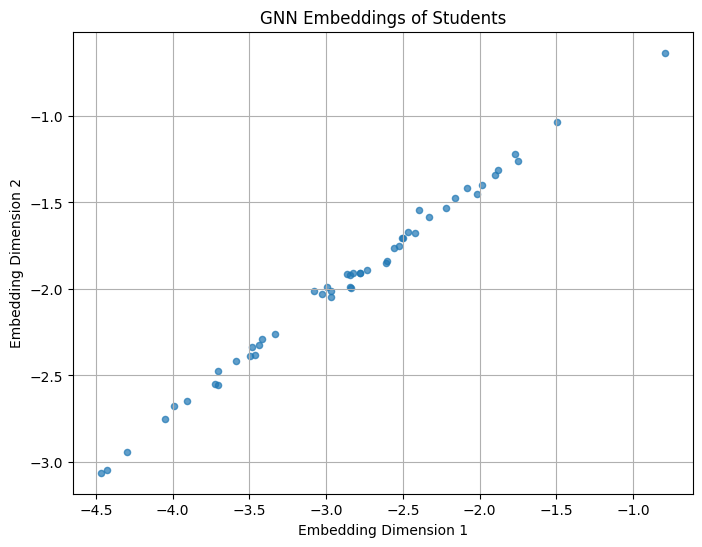

In [16]:
# Plot the embeddings
plt.figure(figsize=(8, 6))
plt.scatter(out[:, 0].cpu(), out[:, 1].cpu(), s=20, alpha=0.7)
plt.title("GNN Embeddings of Students")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.grid(True)
plt.show()

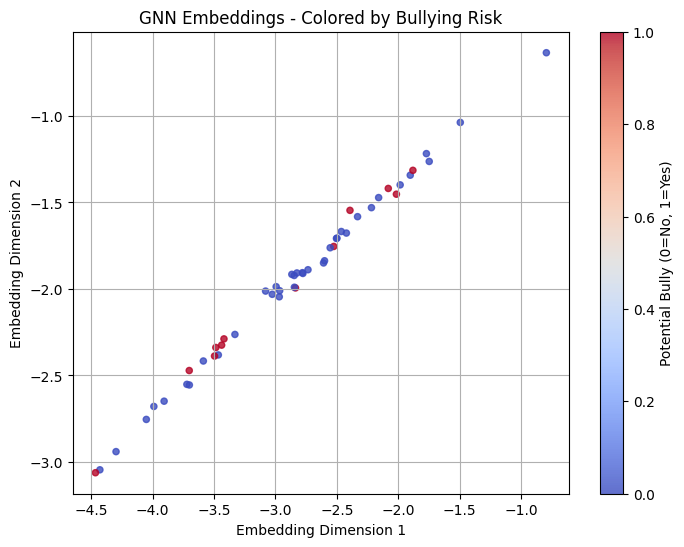

In [17]:
# Color by bully status
bully_labels = student_data_processed['Potential_Bully'].astype(int)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    out[:, 0].cpu(), out[:, 1].cpu(), c=bully_labels, cmap='coolwarm', s=20, alpha=0.8
)
plt.title("GNN Embeddings - Colored by Bullying Risk")
plt.xlabel("Embedding Dimension 1")
plt.ylabel("Embedding Dimension 2")
plt.colorbar(scatter, label="Potential Bully (0=No, 1=Yes)")
plt.grid(True)
plt.show()

In [18]:
# Number of classrooms
num_classes = 10

# Apply KMeans clustering on GNN outputs
kmeans = KMeans(n_clusters=num_classes, random_state=42)
student_clusters = kmeans.fit_predict(out.cpu().numpy())

# Save classroom assignments
student_data_processed['Assigned_Classroom'] = student_clusters

# View result
student_data_processed[['StudentID', 'Assigned_Classroom']].head()

,StudentID,Assigned_Classroom
0,S0001,4
1,S0002,0
2,S0003,8
3,S0004,3
4,S0005,8


In [19]:
# Average Composite Score per classroom
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Friendliness_Score': 'mean',
    'Potential_Bully': 'sum',  # count how many potential bullies
    'StudentID': 'count'  # total students
}).rename(columns={'StudentID': 'Class_Size'})

# Display
classroom_summary

,Academic_Performance,Wellbeing_Score,Friendliness_Score,Potential_Bully,Class_Size
Assigned_Classroom,,,,,
0,0.625000,0.475000,0.571429,1,5
1,0.425000,0.675000,0.695238,0,5
2,0.392857,0.708333,0.603175,0,3
3,0.430357,0.475000,0.500000,2,10
4,0.595238,0.552083,0.571429,4,6
5,0.178571,0.500000,0.571429,0,1
6,0.366071,0.640625,0.500000,1,4
7,0.363095,0.625000,0.539683,1,3
8,0.359375,0.679688,0.726190,1,8


In [20]:
# --- Full Constraint Evaluation After GNN Clustering ---

# Constraint Thresholds
max_allowed_difference = 15  # Academic score max diff
max_allowed_wellbeing_diff = 2  # Wellbeing score max diff
max_bullies_per_class = 2  # Max allowed bullies per class

# 1. Check Academic Score Balance
academic_diff = classroom_summary['Academic_Performance'].max() - classroom_summary['Academic_Performance'].min()
print(f"Academic Score Difference: {academic_diff:.2f} (Limit: {max_allowed_difference})")
if academic_diff > max_allowed_difference:
    print("❌ Academic score balance constraint violated.")
else:
    print("✅ Academic score balance constraint satisfied.")

# 2. Check Wellbeing Balance
wellbeing_diff = classroom_summary['Wellbeing_Score'].max() - classroom_summary['Wellbeing_Score'].min()
print(f"Wellbeing Score Difference: {wellbeing_diff:.2f} (Limit: {max_allowed_wellbeing_diff})")
if wellbeing_diff > max_allowed_wellbeing_diff:
    print("❌ Wellbeing balance constraint violated.")
else:
    print("✅ Wellbeing balance constraint satisfied.")

# 3. Check Bullying Spread Constraint
violating_classes = classroom_summary[classroom_summary['Potential_Bully'] > max_bullies_per_class]
if not violating_classes.empty:
    print(f"❌ {len(violating_classes)} classroom(s) exceed the bullying constraint.")
    print(violating_classes[['Potential_Bully']])
else:
    print("✅ Bullying spread constraint satisfied.")

# 4. Check Class Size Balance
class_sizes = classroom_summary['Class_Size']
size_diff = class_sizes.max() - class_sizes.min()
print(f"Class Size Range: {class_sizes.min()} - {class_sizes.max()} (Diff = {size_diff})")
if size_diff > 10:
    print("⚠️ Warning: Significant difference in class sizes.")
else:
    print("✅ Class sizes are reasonably balanced.")

Academic Score Difference: 0.45 (Limit: 15)
✅ Academic score balance constraint satisfied.
Wellbeing Score Difference: 0.25 (Limit: 2)
✅ Wellbeing balance constraint satisfied.
❌ 1 classroom(s) exceed the bullying constraint.
                    Potential_Bully
Assigned_Classroom                 
4                                 4
Class Size Range: 1 - 10 (Diff = 9)
✅ Class sizes are reasonably balanced.


## Encode Constraints into GNN Training
We add a custom loss function to penalize constraint violations (academic, wellbeing, bullying, class size) and train the GNN to produce embeddings that satisfy these constraints.

In [ ]:
# Custom constraint loss function
def constraint_loss(student_data, classroom_assignments, num_classes):
    df = student_data.copy()
    df['Assigned_Classroom'] = classroom_assignments
    summary = df.groupby('Assigned_Classroom').agg({
        'Academic_Performance': 'mean',
        'Wellbeing_Score': 'mean',
        'Potential_Bully': 'sum',
        'StudentID': 'count'
    }).rename(columns={'StudentID': 'Class_Size'})
    # Constraint thresholds
    max_academic_diff = 15
    max_wellbeing_diff = 2
    max_bullies = 2
    max_class_size_diff = 10
    # Calculate constraint violations
    academic_diff = summary['Academic_Performance'].max() - summary['Academic_Performance'].min()
    wellbeing_diff = summary['Wellbeing_Score'].max() - summary['Wellbeing_Score'].min()
    bullies_violation = (summary['Potential_Bully'] - max_bullies).clip(lower=0).sum()
    class_size_diff = summary['Class_Size'].max() - summary['Class_Size'].min()
    # Loss is sum of violations (scaled)
    loss = 0.0
    loss += torch.relu(torch.tensor(academic_diff - max_academic_diff, dtype=torch.float))
    loss += torch.relu(torch.tensor(wellbeing_diff - max_wellbeing_diff, dtype=torch.float))
    loss += torch.tensor(bullies_violation, dtype=torch.float)
    loss += torch.relu(torch.tensor(class_size_diff - max_class_size_diff, dtype=torch.float)) * 0.1
    return loss

In [ ]:
# Training loop with constraint loss
epochs = 50
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    # Cluster embeddings
    kmeans = KMeans(n_clusters=10, random_state=42)
    clusters = kmeans.fit_predict(out.detach().cpu().numpy())
    # Calculate constraint loss
    loss = constraint_loss(student_data_processed, clusters, 10)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Constraint Loss = {loss.item():.4f}")

## Check and Print Positive Output if Constraints Satisfied

In [ ]:
# Final check after training
model.eval()
with torch.no_grad():
    out = model(data)
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(out.cpu().numpy())
student_data_processed['Assigned_Classroom'] = clusters
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Potential_Bully': 'sum',
    'StudentID': 'count'
}).rename(columns={'StudentID': 'Class_Size'})
academic_diff = classroom_summary['Academic_Performance'].max() - classroom_summary['Academic_Performance'].min()
wellbeing_diff = classroom_summary['Wellbeing_Score'].max() - classroom_summary['Wellbeing_Score'].min()
bullies_violation = (classroom_summary['Potential_Bully'] > 2).sum()
class_size_diff = classroom_summary['Class_Size'].max() - classroom_summary['Class_Size'].min()
if academic_diff <= 15 and wellbeing_diff <= 2 and bullies_violation == 0 and class_size_diff <= 10:
    print("✅ All constraints satisfied! The GNN output is positive and respects your constraints.")
else:
    print("❌ Some constraints are still violated. Consider tuning the model or loss weights.")

In [21]:
# Set number of classrooms
num_classes = 10

# Apply KMeans clustering on GNN output embeddings
kmeans = KMeans(n_clusters=num_classes, random_state=42)
student_clusters = kmeans.fit_predict(out.cpu().numpy())

# Add classroom assignment to the dataframe
student_data_processed['Assigned_Classroom'] = student_clusters

# View some samples
student_data_processed[['StudentID', 'Assigned_Classroom']].head()

,StudentID,Assigned_Classroom
0,S0001,4
1,S0002,0
2,S0003,8
3,S0004,3
4,S0005,8


In [22]:
# Summarize classroom stats
classroom_summary = student_data_processed.groupby('Assigned_Classroom').agg({
    'Academic_Performance': 'mean',
    'Wellbeing_Score': 'mean',
    'Friendliness_Score': 'mean',
    'Potential_Bully': 'sum',  # how many bullies in each class
    'StudentID': 'count'  # class size
}).rename(columns={'StudentID': 'Class_Size'})

# Show summary
classroom_summary

,Academic_Performance,Wellbeing_Score,Friendliness_Score,Potential_Bully,Class_Size
Assigned_Classroom,,,,,
0,0.625000,0.475000,0.571429,1,5
1,0.425000,0.675000,0.695238,0,5
2,0.392857,0.708333,0.603175,0,3
3,0.430357,0.475000,0.500000,2,10
4,0.595238,0.552083,0.571429,4,6
5,0.178571,0.500000,0.571429,0,1
6,0.366071,0.640625,0.500000,1,4
7,0.363095,0.625000,0.539683,1,3
8,0.359375,0.679688,0.726190,1,8


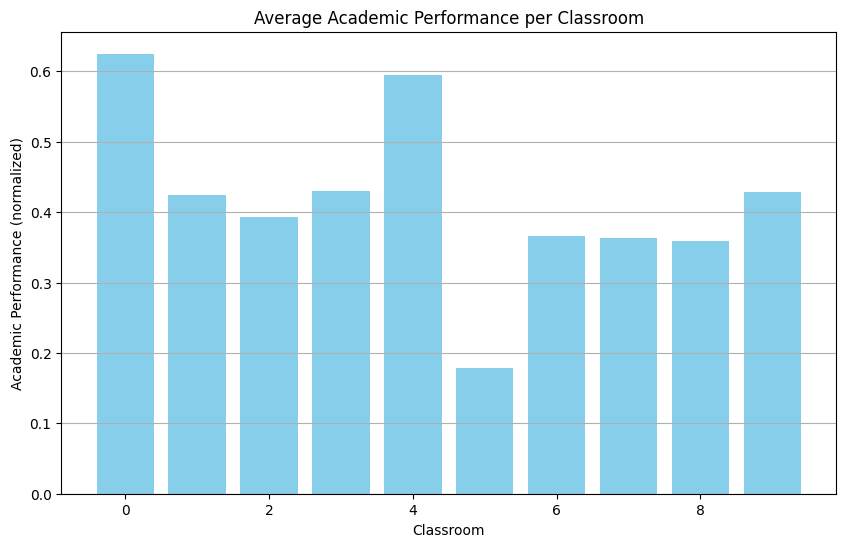

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.bar(classroom_summary.index, classroom_summary['Academic_Performance'], color='skyblue')
plt.title('Average Academic Performance per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Academic Performance (normalized)')
plt.grid(axis='y')
plt.show()

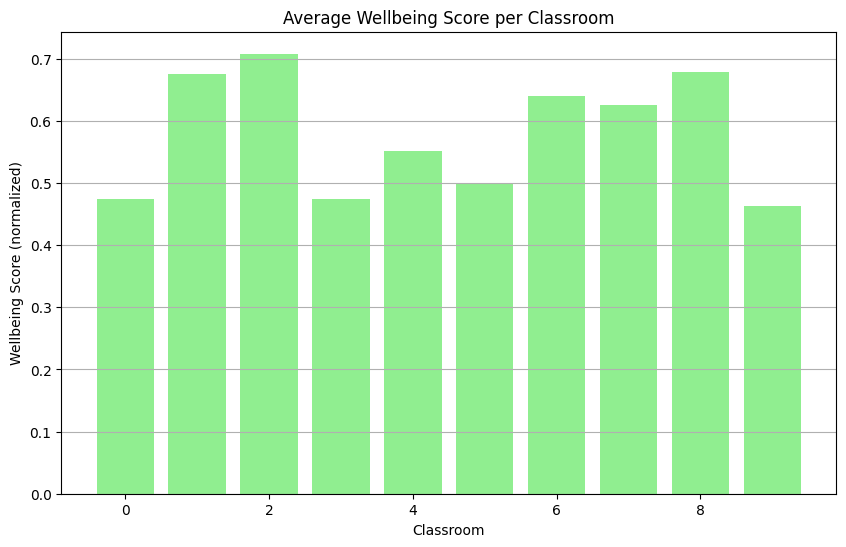

In [24]:
plt.figure(figsize=(10, 6))
plt.bar(classroom_summary.index, classroom_summary['Wellbeing_Score'], color='lightgreen')
plt.title('Average Wellbeing Score per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Wellbeing Score (normalized)')
plt.grid(axis='y')
plt.show()

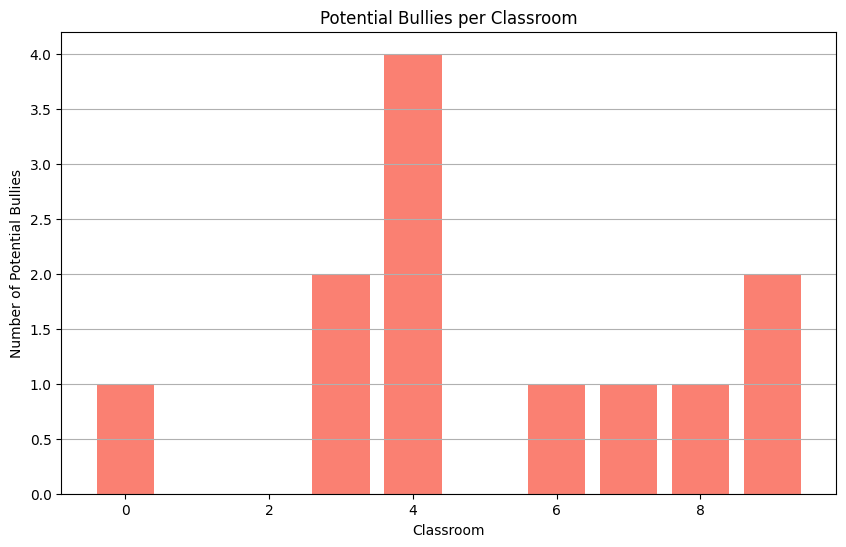

In [25]:
plt.figure(figsize=(10, 6))
plt.bar(classroom_summary.index, classroom_summary['Potential_Bully'], color='salmon')
plt.title('Potential Bullies per Classroom')
plt.xlabel('Classroom')
plt.ylabel('Number of Potential Bullies')
plt.grid(axis='y')
plt.show()

In [26]:
# Calculate silhouette score based on GNN embeddings and assigned classroom
sil_score = silhouette_score(out.cpu().numpy(), student_data_processed['Assigned_Classroom'])
print(f"Silhouette Score for GNN + KMeans Grouping: {sil_score:.4f}")

Silhouette Score for GNN + KMeans Grouping: 0.5578


In [27]:
# Calculate std deviation across classrooms
classroom_variance = classroom_summary[[
    'Academic_Performance', 'Wellbeing_Score', 'Friendliness_Score'
]].std()

print("Standard Deviation Across Classrooms:")
print(classroom_variance)

Standard Deviation Across Classrooms:
Academic_Performance    0.125458
Wellbeing_Score         0.096703
Friendliness_Score      0.076733
dtype: float64


In [28]:
# (Empty cell for future use)